# **Tutorial 3: Transfer Learning**

### Load libraries

In [ ]:
!pip install torchsummary
!pip install --upgrade torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import print_function, division
import os
import time
import torch
import torchvision
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import random_split
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy


## 1. Dataset

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

<img src="https://pytorch.org/tutorials/_images/cifar10.png" alt="Alternative text" />


`Notice: We will use torchvision and torch.utils.data packages for loading the
data`

### 1.1 Data Normalization
The input data can come in a variety of sizes. They need to be normalized to a fixed size and format before batches of data are used together for training.

Let us go over the transformations we used for our data augmentation
- *Resize* scales an image to 32x32
- *ToTensor* converts the PIL Image which has values in the range of 0-255 to a floating point Tensor and normalizes them to a range of 0-1, by dividing it by 255
- *Normalize* takes in a 3 channel Tensor and normalizes each channel by the input mean and standard deviation for that channel. Mean and standard deviation vectors are input as 3 element vectors. Each channel in the tensor is normalized as *T = (T – mean)/(standard deviation)*

In [ ]:
# all_transforms = transforms.Compose([
#     transforms.Resize([32, 32]),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
# ])

mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]


train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)])

test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)])


### 1.2 Data loading
Next, let us see how to use the above defined transformations and load the data to be used for training.

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transform)
trainset, valset = random_split(trainset, [42000, 8000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We do not require a full load of data. Instead, we will partition it into sub-data (as determined by batch size) and load accordingly.

In [ ]:
batch_size = 64

 Then we load them using DataLoader. Note that the image transformations we discussed earlier are applied to the data while loading them using the DataLoader. The order of the data is also shuffled

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

Let us show some of the training images

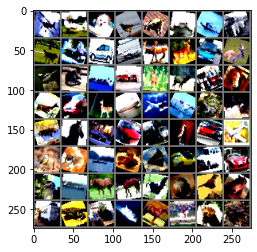

plane plane dog   bird  cat   ship  ship  truck bird  truck car   plane deer  deer  truck deer  bird  cat   ship  truck deer  deer  truck horse deer  car   deer  ship  plane plane frog  deer  deer  horse car   car   truck cat   car   plane bird  dog   ship  cat   plane car   car   car   bird  ship  horse horse dog   bird  bird  horse truck frog  cat   ship  horse horse frog  frog 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


## 2. CNN Training

### 2.1 Training on device
Let’s first define our device as the first visible cuda device if we have CUDA available:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


### 2.1 Define model

It is very hard and time consuming to collect images belonging to a domain of interest and train a classifier from scratch. So, we use a pre-trained model as our base and change the last few layers so we can classify images according to our desirable classes. In this work, we use the pre-trained ResNet18 model.

In [ ]:
from torchvision.models import ResNet18_Weights
# Load pretrained model
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False


fc_input = model.fc.in_features

model.fc = nn.Linear(fc_input, 10)


# # Convert model to be used on GPU
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### 2.2 Define loss function & optimizer

In [ ]:
# Define relevant variables
learning_rate = 0.001
num_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/CIFAR10_experiment')


In [ ]:

dataset_sizes = {'train': len(trainset), 'val': len(valset)}
dataloaders = {'train': trainloader, 'val': valloader}
n_total_steps = len(trainloader)


def train_model(model, criterion, optimizer, scheduler, num_epochs=25, steps = 100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                acc = torch.sum(preds == labels.data)
                running_corrects += acc


                if phase == 'train':
                    # verbose
                    if (i+1) % steps == 0:
                        print(
                            f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, Acc: {acc.item() / preds.size(0):.4f}')
                        ############## TENSORBOARD ########################
                        writer.add_scalar('train/loss', running_loss /
                                        steps, epoch * n_total_steps + i)
                        running_accuracy = running_corrects / steps / preds.size(0)
                        writer.add_scalar('train/accuracy', running_accuracy,
                                        epoch * n_total_steps + i)
                        running_corrects = 0
                        running_loss = 0.0


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # deep copy the model
            if phase == 'val':
                print('Validation Loss: {:.4f} Acc: {:.4f}'.format(
                    epoch_loss, epoch_acc))

                ############## TENSORBOARD ########################
                writer.add_scalar('validation/loss', epoch_loss, epoch)
                running_accuracy = running_corrects / \
                    steps / preds.size(0)
                writer.add_scalar('validation/accuracy', epoch_acc,
                                  epoch)

                # save the best result
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model = train_model(model, criterion, optimizer,
                         lr_scheduler, num_epochs)


Epoch 1/20
----------
Epoch [1/20], Step [100/657], Loss: 2.2579, Acc: 0.2031
Epoch [1/20], Step [200/657], Loss: 2.2383, Acc: 0.1719
Epoch [1/20], Step [300/657], Loss: 2.2057, Acc: 0.2031
Epoch [1/20], Step [400/657], Loss: 2.1502, Acc: 0.1719
Epoch [1/20], Step [500/657], Loss: 2.0928, Acc: 0.2031
Epoch [1/20], Step [600/657], Loss: 2.1007, Acc: 0.2031
Validation Loss: 2.1117 Acc: 0.2425

Epoch 2/20
----------
Epoch [2/20], Step [100/657], Loss: 2.1817, Acc: 0.1719
Epoch [2/20], Step [200/657], Loss: 2.1693, Acc: 0.1562
Epoch [2/20], Step [300/657], Loss: 2.0134, Acc: 0.2656
Epoch [2/20], Step [400/657], Loss: 1.9198, Acc: 0.3281
Epoch [2/20], Step [500/657], Loss: 2.1736, Acc: 0.1875
Epoch [2/20], Step [600/657], Loss: 1.9292, Acc: 0.2969
Validation Loss: 1.9604 Acc: 0.3004

Epoch 3/20
----------
Epoch [3/20], Step [100/657], Loss: 2.0784, Acc: 0.2812
Epoch [3/20], Step [200/657], Loss: 1.8224, Acc: 0.4062
Epoch [3/20], Step [300/657], Loss: 1.9433, Acc: 0.3438
Epoch [3/20], Step [

## 3. Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


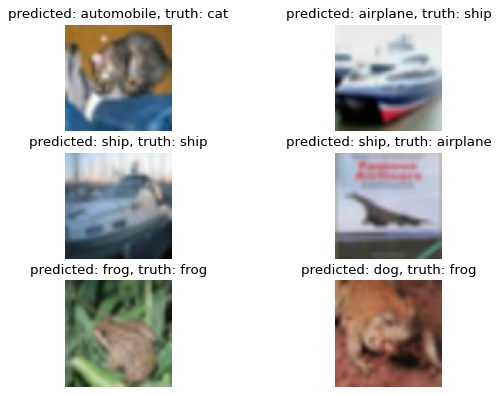

In [ ]:
class_names = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat',
               4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
def visualize_image(model, dataloader,  num_images = 6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8, 6), dpi=80)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, truth: {}'.format(
                    class_names[preds[j].item()], class_names[labels[j].item()]))
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = std * img + mean
                ax.imshow(img)

                if images_so_far == num_images:
                    return

visualize_image(model, testloader)

In [ ]:
model.eval()
acc = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        acc += torch.sum(preds == labels.data)
    
print(f'Accuracy on Test Data: {acc * 100/ len(testset):.4f}%')


Accuracy on Test Data: 47.1900%
